In [39]:
# Importing libraries
from copy import deepcopy

# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score, mean_squared_error # Calculate the accuracy

# Loading Bar
from time import sleep
from tqdm import tqdm
import time

# Linear programming
from scipy.optimize import linprog


# Convex Hull
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet
from scipy.spatial.distance import euclidean


# Supress warnings
import warnings; warnings.simplefilter('ignore')

In [40]:
# Loading Dataset
adult_folder = pd.read_csv('adult.csv') # Loading Adult

In [41]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [42]:
adult_dataset = Adult_Data_Clean(adult_folder)

# Separating label (income) from the rest of the data and making income binary
income_raw = adult_dataset['income'].tolist()
adult_dataset = adult_dataset.drop(['income'], axis=1)
income = pd.Series(income_raw).astype('category').cat.codes.tolist()

In [43]:
# One-Hot encoding
per_adult_encoded = pd.get_dummies(adult_dataset)
print("Total number of columns = " + str(len(per_adult_encoded.columns)))

Total number of columns = 104


In [44]:
def d_dimensional_dataset(df, d):
    "return dataset with d columns"
    return df.sample(n=d, axis='columns')

In [53]:
# Spliting dataset
df = d_dimensional_dataset(per_adult_encoded, 20)
X_train, X_test, Y_train, Y_test = train_test_split(df, income, test_size = 0.2, random_state = 0)

In [54]:
# Trining the Logistic regression classifier
logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(X_train, Y_train)

#Predicting
y_test_pred = logistic.predict(X_test)
y_train_pred = logistic.predict(X_train)

In [55]:
def test(model, qtd_data, x, y):
    #Predicting
    y_test_pred = model.predict(x[0:qtd_data])
    #y_train_pred = model.predict(X_train)

    # Getting accuracy for the personalized classifier
    #per_train_acc = accuracy_score(Y_train, y_train_pred)
    per_test_acc = accuracy_score(y[0:qtd_data], y_test_pred)
    
    # L2 score
    #l2_train_acc = mean_squared_error(Y_train, y_train_pred)
    l2_test_acc = mean_squared_error(y[0:qtd_data], y_test_pred)
    
    return per_test_acc,l2_test_acc

In [56]:
def load_model(mw, pivot):
    "Load a model with new wights given by mw"
    model = deepcopy(pivot)
    model.coef_ = mw
    return model

In [65]:
center = logistic.coef_
step = .01 #step size for each step in an direction
samples = 100 #number of directions
epsilon = 0.0001 #Rashomon set size

extremes = np.zeros((samples, center.size))

for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + step * Z
    #loading model
    lg = load_model(direction, logistic)
    ct = 0
    while (test(lg, -1, X_test, Y_test)[1] - test(logistic, -1, X_test, Y_test)[1]) < epsilon:
        extremes[i, :] = direction
        direction *= (1+step)
        lg = load_model(direction, logistic)
        ct+=1

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.43it/s]


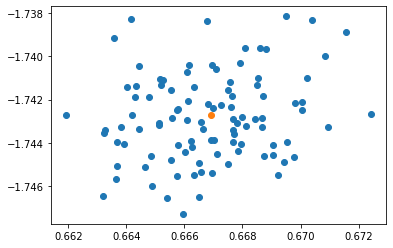

In [66]:
plt.plot(extremes[:, 0], extremes[:, 1], 'o')
plt.plot(center[:, 0], center[:, 1], 'o')

(80, 12)

In [13]:
# Sampling from Rashomon set
def samp_in_hull(points, n):
    dims = points.shape[-1] #get dim
    hull = points[ConvexHull(points).vertices] #get hull
    deln = hull[Delaunay(hull).simplices] #get Delunay

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum()) 

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

In [14]:
def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

In [ ]:
def find_max_dist(L):
    max_dist = math.dist(L[0], L[1])
    for i in range(0, len(L)-1):
        for j in range(i+1, len(L)):
            max_dist = max(math.dist(L[i], L[j]), max_dist)
            point_1 = L[i]
            point_2 = L[j]
    return max_dist, point_1, point_2

In [38]:
in_hull(extremes, center[0])

points = extremes
x = center[0]

n_points = len(points)
n_dim = len(x)
    
c = np.zeros(n_points)
A = np.r_[points.T,np.ones((1,n_points))]

b = np.r_[x, np.ones(1)]

lp = linprog(c, A_eq=A, b_eq=b)

lp n

     con: array([ 9.06275055e-13,  3.35509398e-12,  8.43414227e-12,  5.50282042e-12,
       -2.76223489e-12,  8.97026897e-12, -7.54685203e-12, -1.03999032e-11,
       -7.71605002e-14,  4.44227988e-14,  9.83865767e-13,  1.42885703e-12,
        6.70064004e-12,  7.82880705e-14,  3.04756220e-12,  6.76592116e-12])
     fun: 0.0
 message: 'Optimization terminated successfully.'
     nit: 10
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1.06116677e-04, 2.18663259e-05, 2.18663259e-05, 2.18663259e-05,
       2.18663259e-05, 6.07953239e-02, 1.54552317e-04, 2.30008173e-04,
       1.06504429e-01, 7.35660714e-05, 8.02024947e-05, 2.18663259e-05,
       2.90539326e-05, 1.45373574e-04, 1.61142444e-02, 2.18663259e-05,
       5.99246859e-05, 2.18663259e-05, 5.43228670e-04, 3.32796729e-05,
       2.18663259e-05, 1.14447992e-04, 6.79172485e-03, 2.18663259e-05,
       5.10621281e-02, 2.08034953e-04, 6.79944881e-05, 2.18663259e-05,
       7.54096473e-05, 5.29598444e-02, 2.18

In [ ]:
def ef_samp_in_hull(center, points, n):

    #find maximum distance (can be faster)
    max_dist = math.dist(points[0], center[0])
    for i in range(len(points)):
        if max_dist< math.dist(points[i], center[0]):
            max_dist = math.dist(points[i], center[0])
    
#     # Sampling 
#     samples = np.zeros((n, points.shape[1]))
#     count = 0
#     while count < n:
#         Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
#         Z = Z/np.linalg.norm(Z)
#         x = center[0] + max_dist * Z
#         pt = in_hull(points, x)
#         if pt:
#             samples[count] = x
#             count +=1
        
    
    return max_dist

In [ ]:
print(in_hull(extremes, center[0]))

In [ ]:
ef_samp_in_hull(center, extremes, 1)

In [ ]:
def get_samples_for_dimension(d):
    df = d_dimensional_dataset(per_adult_encoded, d)
    X_train, X_test, Y_train, Y_test = train_test_split(df, income, test_size = 0.5, random_state = 0)
    
    # Trining the Logistic regression classifier
    logistic = LogisticRegression(solver = 'liblinear')
    logistic.fit(X_train, Y_train)

    #Predicting
    y_test_pred = logistic.predict(X_test)
    y_train_pred = logistic.predict(X_train)
    
    #Finding points in the border of the Rashomon set
    center = logistic.coef_
    delta = .005 #Size of initial noise
    step = 1 #step size for each step in an direction
    samples = 100 #number of directions
    epsilon = 0.001 #Rashomon set size

    extremes = np.zeros((samples, center.size))

    for i in range(samples):
        #Generationg direction
        Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
        Z = Z/np.linalg.norm(Z)
        direction = center + delta * Z
        #loading model
        lg = load_model(direction, logistic)
        ct = 0
        while (test(lg, -1, X_test, Y_test)[1] - test(logistic, -1, X_test, Y_test)[1]) < epsilon and ct < 20:
            extremes[i, :] = direction
            direction *= (1 + step)
            lg = load_model(direction, logistic)
            ct+=1
    
    start = time.time()
    samp_in_hull(extremes, 100)
    end = time.time()

    return end - start

In [ ]:
get_samples_for_dimension(5)

In [ ]:
qtd_t = 7
dims = range(2, qtd_t+2)
times = np.zeros(qtd_t)


for i in tqdm(range(qtd_t)):
    times[i] = get_samples_for_dimension(dims[i])
    
    

In [ ]:
plt.plot(dims, times)
plt.xlabel('Dimension')
plt.ylabel('Time (s)')